In [1]:
%load_ext autoreload
%autoreload 2
import comethylation, get_data, analysis, utils

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [29]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

## Read in data

In [7]:
# set args
illum_cpg_locs_fn = "/cellar/users/zkoch/methyl_mut_proj/data/illumina_cpg_450k_locations.csv"
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_072422"
data_dirs = glob.glob( os.path.join("/cellar/users/zkoch/methyl_mut_proj/data", "tcga*data"))

In [11]:
data_dirs = data_dirs[:2]

In [13]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, run_name, dataset_names_list = get_data.main(illum_cpg_locs_fn, out_dir, data_dirs)

Getting methylation for lungadeno
Getting methylation for headneck


## Do mutation analyses

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/cellar/users/zkoch/methylation_and_mutation/analysis.py:73: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  f.write("Effect size: {}\n".format( ct_mutation_in_measured_cpg_df.mean()))
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


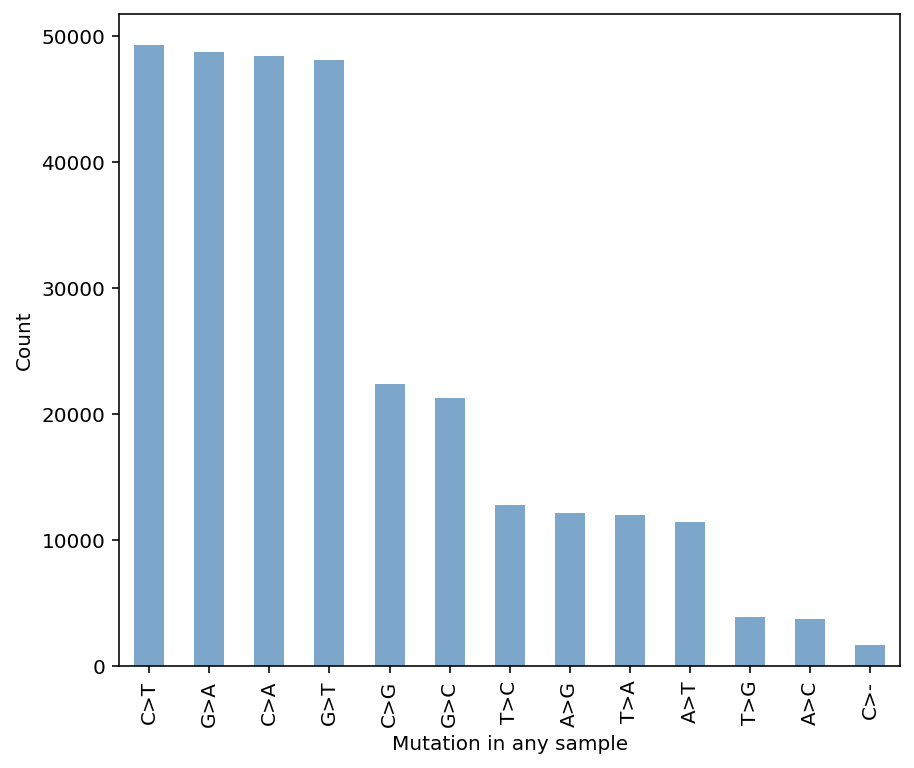

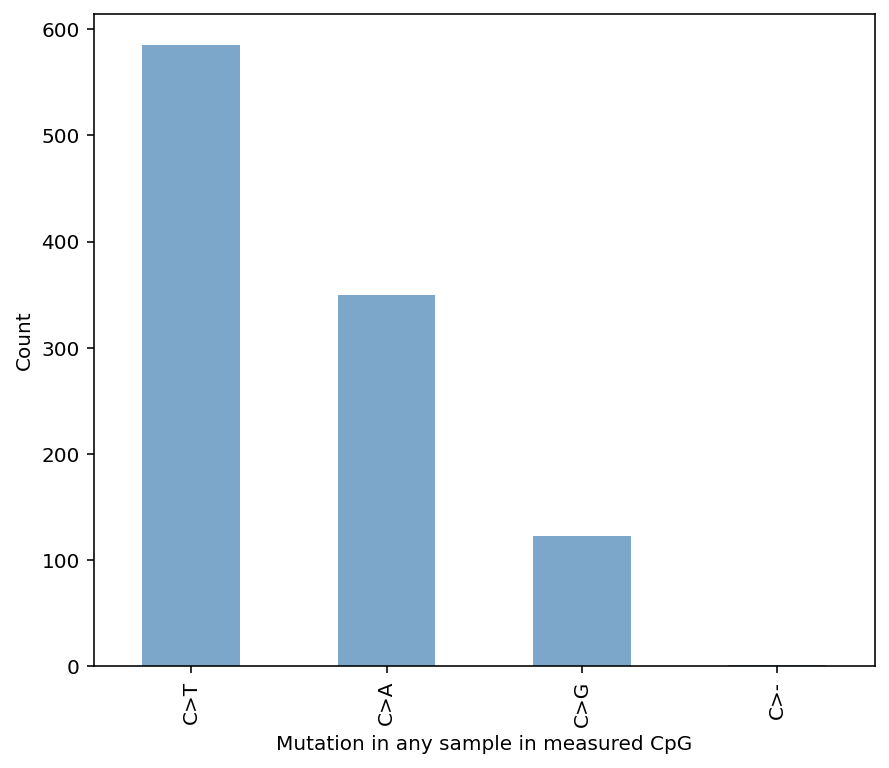

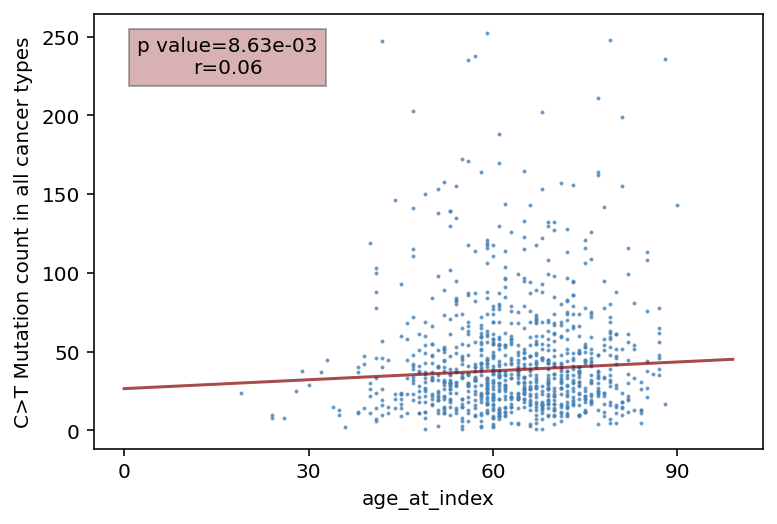

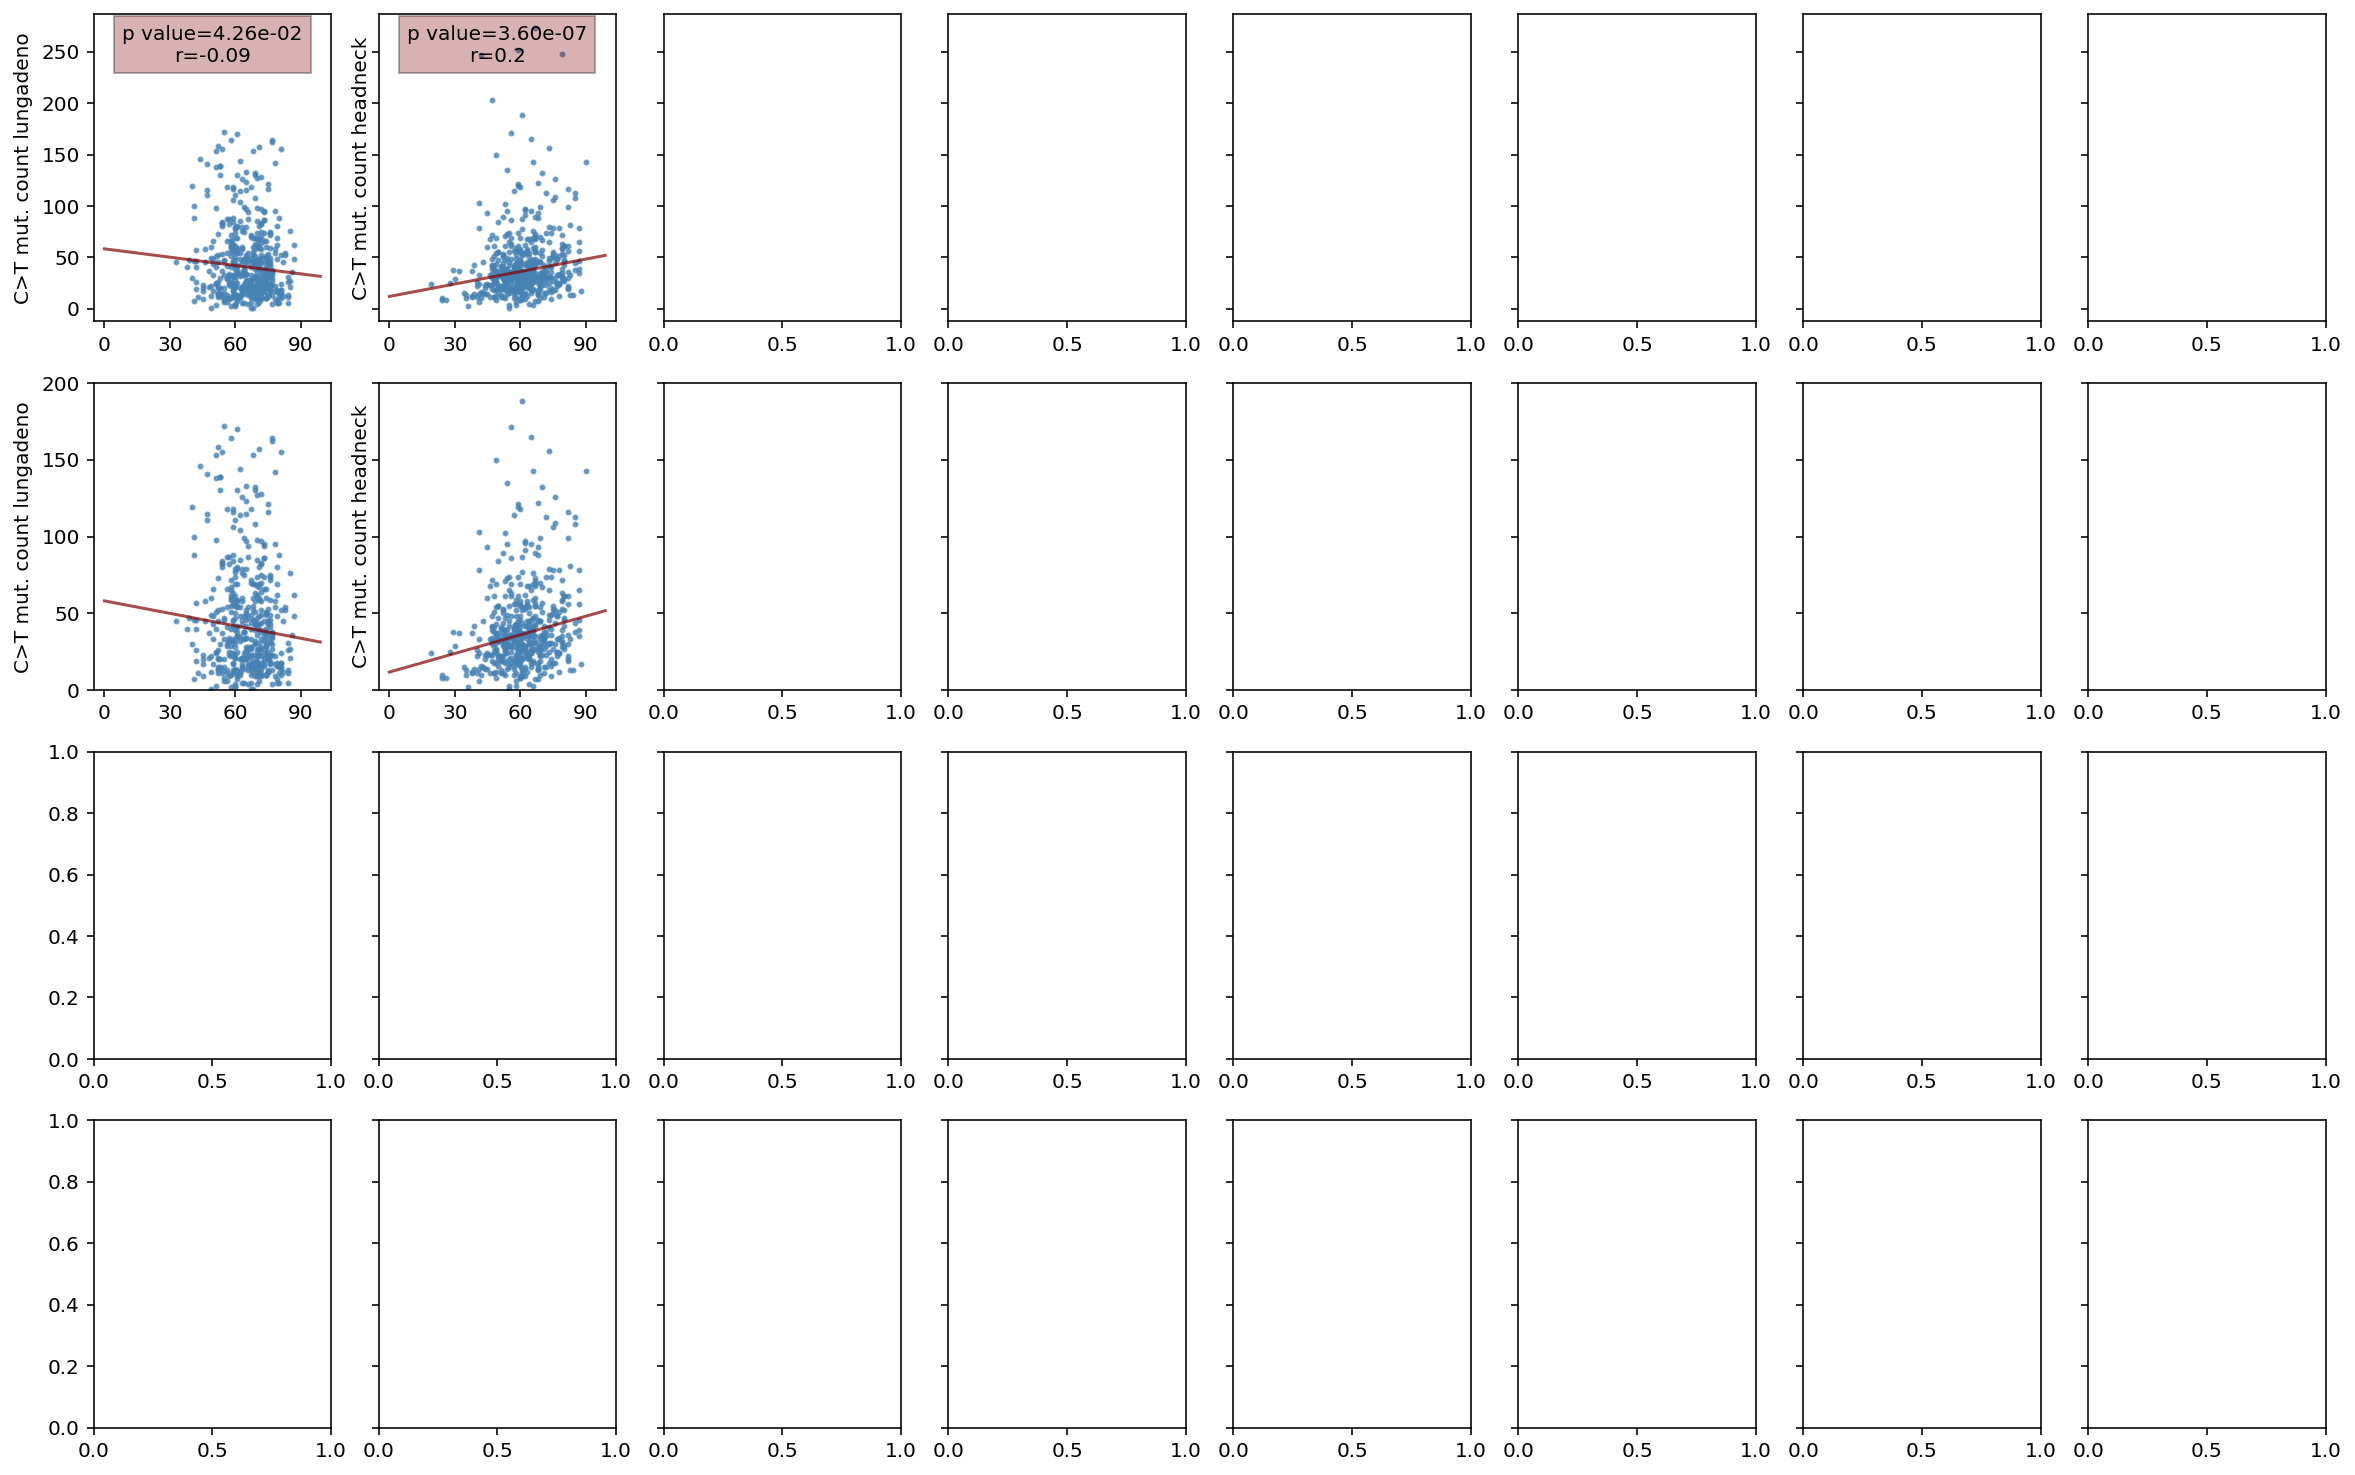

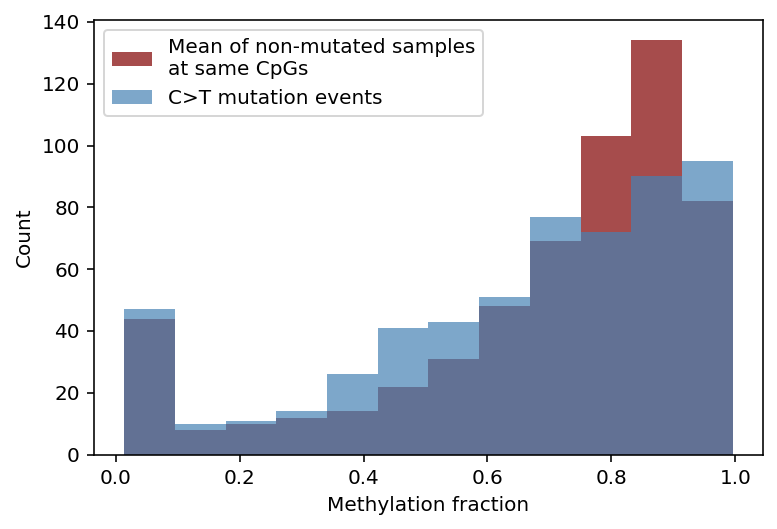

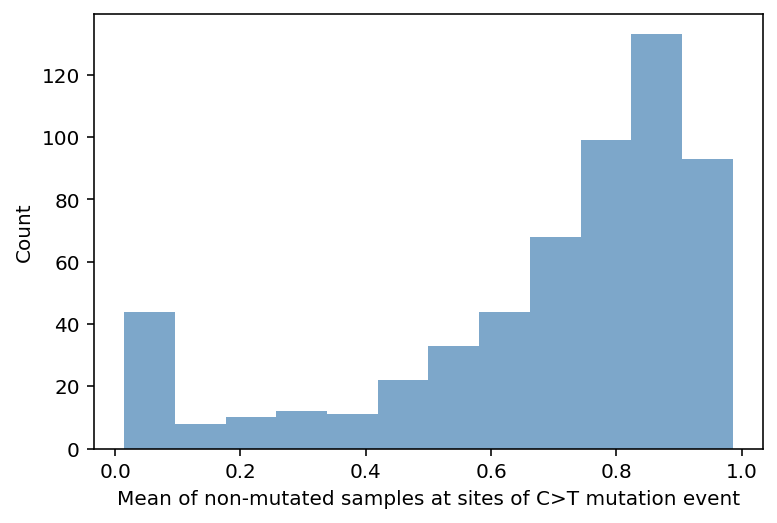

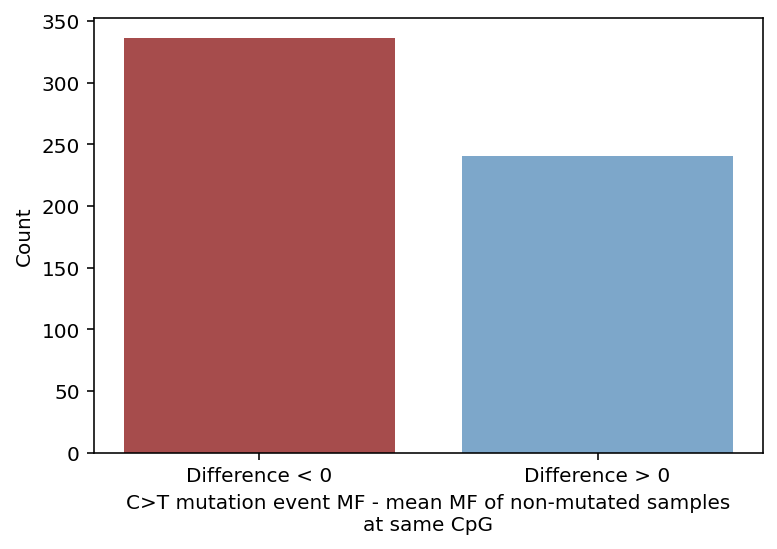

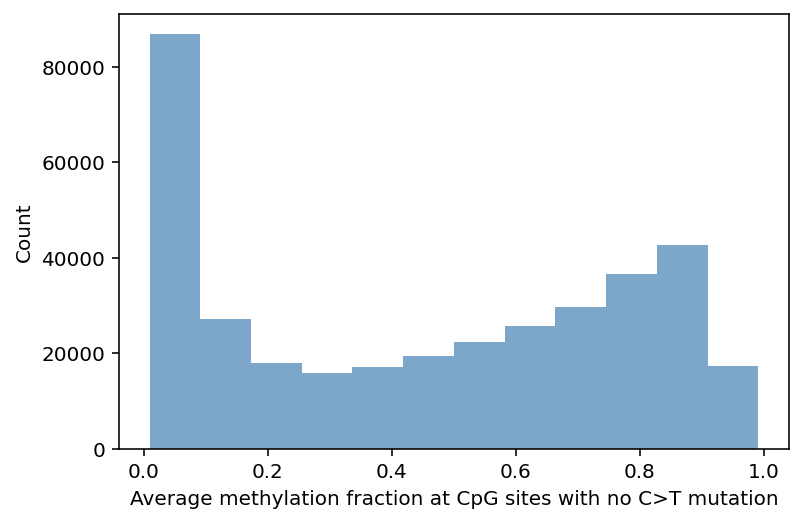

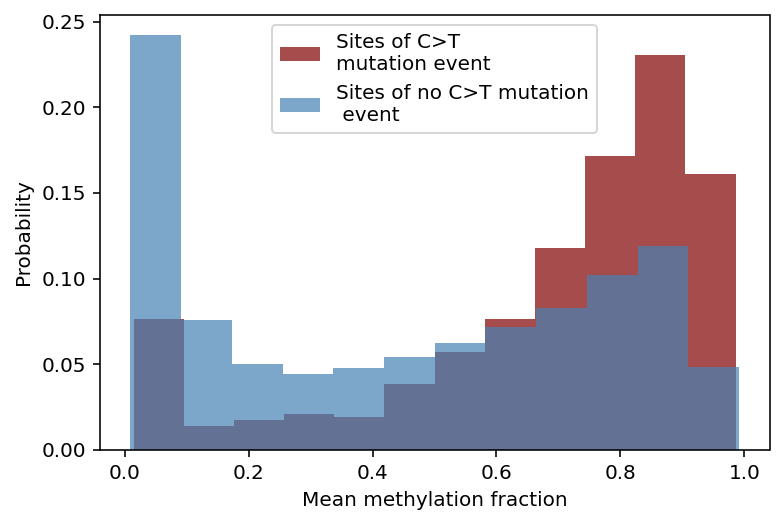

In [18]:
mut_in_measured_cpg_df, ct_mut_in_measured_cpg_df, ct_mut_in_measured_cpg_w_methyl_df = analysis.main(illumina_cpg_locs_df, out_dir, all_mut_df, all_methyl_df_t, all_meta_df, dataset_names_list) 

In [19]:
# save ct_mut_in_measured_cpg_w_methyl_df
ct_mut_in_measured_cpg_w_methyl_df.to_parquet(os.path.join(out_dir, "ct_mut_in_measured_cpg_w_methyl_df.parquet"))

## Do comethylation analysis

In [23]:
corr_fns = sorted(glob.glob( "/cellar/users/zkoch/methyl_mut_proj/corr_matrices/chr_1*.parquet"))

In [ ]:
result_dfs = comethylation.main(corr_fns, illumina_cpg_locs_df, ct_mut_in_measured_cpg_w_methyl_df, all_meta_df, all_methyl_df_t, out_dir)

In [30]:
# read in previously computed results
# read in result dfs
result_dfs = []
for i in np.flip(np.linspace(0.01, .99, 10)):
    res_df = pd.read_parquet(os.path.join("/cellar/users/zkoch/methyl_mut_proj/output_tcga4_jupyter_summer"
,"result_100_sites_varying_percentile_chr1_linked_sites_df_{}.parquet".format(i)))
    result_dfs.append(res_df)

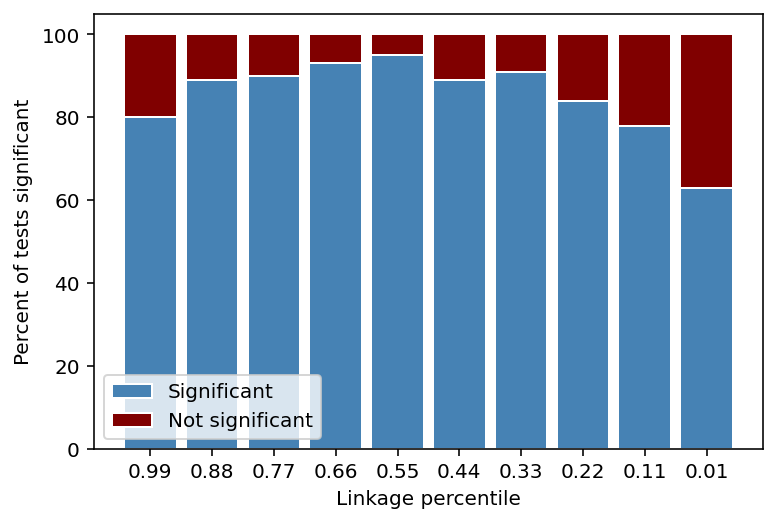

In [32]:
comethylation.plot_sig_bars(result_dfs)

In [ ]:
# new output figure
